In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import copy
import pickle
import io
from itertools import permutations
from simulators.turin import turin

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [69]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

        
def load_models(root_name: str, device: torch.device):
    sum_net = torch.load(f"{root_name}/sum_net.pkl", map_location=device)

    density_estimator = torch.load(f"{root_name}/density_estimator.pkl", map_location=device)

    with open(f"{root_name}/posterior_new.pkl", "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, posterior


def read_rnpe(model="turin", misspecified=0, seed=1, theta=[4,10]):
    file = f"seed={seed}_{model}"

    results_dir = f"objects/rnpe/{model}/"
    fn = f"{results_dir}/{file}.pickle"

    with open(fn, "rb") as f:
        results = pickle.load(f)

    return np.array(results['posterior_samples']['RNPE'])


def sample_posteriors(posterior, obs, num):
    return posterior.sample((num,), x=obs.reshape(1, 1, 100, 801), show_progress_bars=True)

In [3]:
def temporalMomentsGeneral(Y, K=4, B=4e9):
    M, N, Ns = Y.shape
#     delta_f = B / (Ns-1)
#     t_max = 1 / delta_f
    tau = np.linspace(0, 100, Ns)
    out = np.zeros((M, N, K))
    for m in range(M):
        for k in range(K):
            for i in range(N):
                y = np.fft.ifft(Y[m, i, :])
                out[m, i, k] = np.trapz(tau**(k) * (np.abs(y)**2), tau)
    return np.log(out)

In [76]:
prior = [[1e-9, 1e-8], [1e-9, 1e-8], [1e7, 5e9], [1e-10, 1e-9]]

theta = torch.tensor(np.load("data/turin_theta_2000_tau0.npy"))
x = torch.tensor(np.load("data/turin_x_2000_tau0.npy")).reshape(2000, 100, 801)

simulator = turin(B=4e9, Ns=801, N=1, tau0=6e-9)
theta_gt = torch.tensor([10**(-8.4), 7.8e-9, 1e9, 2.8e-10])
obs_sim = simulator(theta_gt).to(device)

obs_real = torch.tensor(np.load("data/turin_obs.npy")).float()

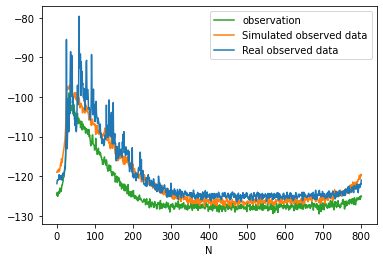

In [22]:
plt.plot(np.arange(801), torch.mean(x[10], axis=0), color="tab:green", label="observation")
plt.plot(np.arange(801), torch.mean(obs_sim, axis=0), color="tab:orange", label="Simulated observed data")
plt.plot(np.arange(801), torch.mean(obs_real, axis=0), color="tab:blue", label="Real observed data")

plt.legend()
plt.xlabel("N")
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


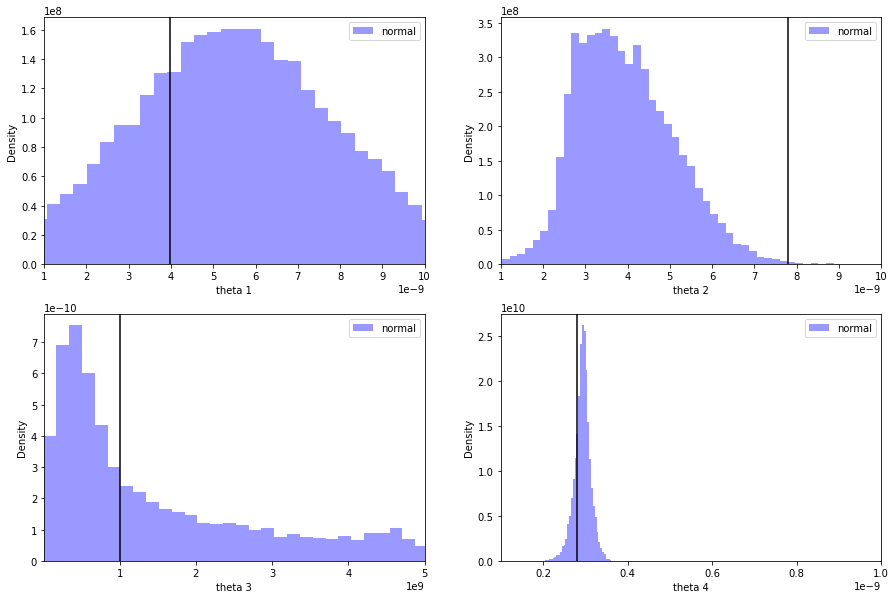

In [37]:
root_name = "objects/turin/none_beta=2.0_num=2000_N=100_tau0_small/4"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)
obs_real_small = temporalMomentsGeneral(obs_real.reshape(1, 100, 801))
obs_sim_small = temporalMomentsGeneral(obs_sim.reshape(1, 100, 801))
post_samples_cont = posterior_normal.sample((10000,), x=obs_real_small.reshape(1, 1, 100, 4))
post_samples_normal = posterior_normal.sample((10000,), x=obs_sim_small.reshape(1, 1, 100, 4))

plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.axvline(x=theta_gt[i],ls="-",c="black")
    sns.distplot(post_samples_cont[:, i].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
    plt.legend()
    plt.xlim(prior[i][0], prior[i][1])
#     plt.title(f"Corrupted data - theta {i+1}")
    plt.xlabel(f"theta {i+1}")
    plt.ylabel("Density")
#     plt.xscale("log")
plt.show()


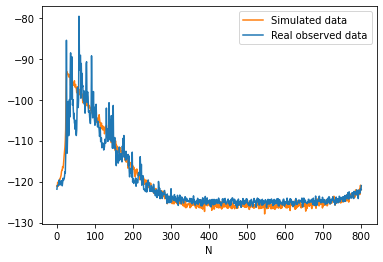

In [62]:
theta_gt = torch.tensor([2e-9, 8e-9, 1e10, 3.5e-10])
obs_sim = simulator(theta_gt).to(device)

plt.plot(np.arange(801), torch.mean(obs_sim, axis=0), color="tab:orange", label="Simulated data")
plt.plot(np.arange(801), torch.mean(obs_real, axis=0), color="tab:blue", label="Real observed data")

plt.legend()
plt.xlabel("N")
plt.show()

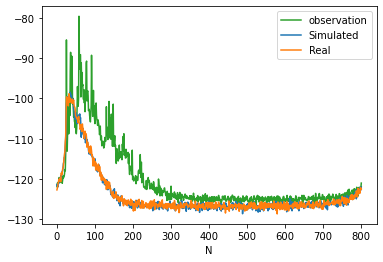

In [38]:
plt.plot(np.arange(801), torch.mean(obs_real, axis=0), color="tab:green", label="observation")
# plt.plot(np.arange(801), torch.mean(obs_sim, axis=0), color="tab:blue", label="Simulated observed data")

predictive_samples_normal = simulator(torch.mean(post_samples_normal, axis=0))
plt.plot(np.arange(801), torch.mean(predictive_samples_normal, axis=0), color="tab:blue", label="Simulated")

predictive_samples_cont = simulator(torch.mean(post_samples_cont, axis=0))
plt.plot(np.arange(801), torch.mean(predictive_samples_cont, axis=0), color="tab:orange", label="Real")

# predictive_samples_robust = simulator(torch.mean(post_samples_robust_cont, axis=0))
# plt.plot(np.arange(801), torch.mean(predictive_samples_robust, axis=0), color="tab:blue", label="NPE-RS")

plt.legend()
plt.xlabel("N")
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


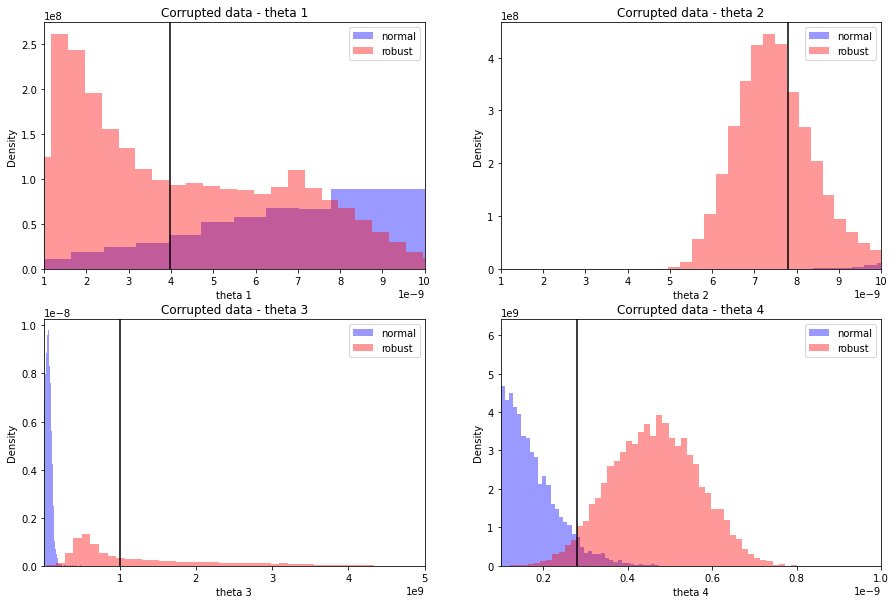

In [157]:
root_name = "objects/turin/none_num=2000_N=100_tau0/4"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)
root_name = "objects/turin/mmd_beta=2.0_num=2000_N=100_tau0/12"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_real.reshape(1, 1, 100, 801))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_real.reshape(1, 1, 100, 801))

plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.axvline(x=theta_gt[i],ls="-",c="black")
    sns.distplot(post_samples_normal_cont[:, i].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
    sns.distplot(post_samples_robust_cont[:, i].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
    plt.legend()
    plt.xlim(prior[i][0], prior[i][1])
    plt.title(f"Corrupted data - theta {i+1}")
    plt.xlabel(f"theta {i+1}")
    plt.ylabel("Density")
    
plt.show()


In [74]:
post_samples_rnpe_cont = torch.tensor(read_rnpe(seed=1))

/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

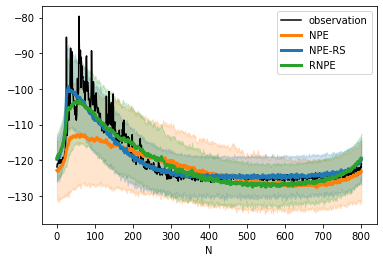

In [123]:
simulator = turin(B=4e9, Ns=801, N=1, tau0=6e-9)
plt.plot(np.arange(801), torch.mean(obs_real, axis=0), color="black", label="observation")

N_samples = 500
xp = range(801)

npe_mean = torch.zeros([N_samples, 801])
for i in range(N_samples):
    npe_mean[i] = simulator(post_samples_normal_cont[i])
mean = torch.mean(npe_mean, dim=0)
std = torch.std(npe_mean, dim=0)
sns.lineplot(xp, mean, color="tab:orange", alpha=1, linewidth=3, label="NPE")
plt.fill_between(xp, mean - std, mean + std, color="tab:orange", alpha=0.2)


our_mean = torch.zeros([N_samples, 801])
for i in range(N_samples):
    our_mean[i] = simulator(post_samples_robust_cont[i])
mean = torch.mean(our_mean, dim=0)
std = torch.std(our_mean, dim=0)
sns.lineplot(xp, mean, color="tab:blue", alpha=1, linewidth=3, label="NPE-RS")
plt.fill_between(xp, mean - std, mean + std, color="tab:blue", alpha=0.2)


rnpe_mean = torch.zeros([N_samples, 801])
for i in range(N_samples):
    rnpe_mean[i] = simulator(post_samples_rnpe_cont[i])
mean = torch.mean(rnpe_mean, dim=0)
std = torch.std(rnpe_mean, dim=0)
sns.lineplot(xp, mean, color="tab:green", alpha=1, linewidth=3, label="RNPE")
plt.fill_between(xp, mean - std, mean + std, color="tab:green", alpha=0.2)


plt.legend()
plt.xlabel("N")
plt.show()

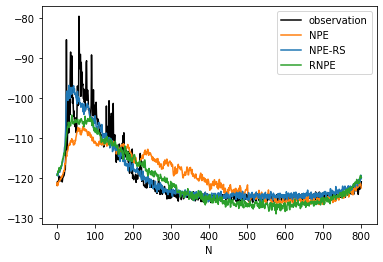

In [124]:
simulator = turin(B=4e9, Ns=801, N=100, tau0=6e-9)
# np.save("post_samples_npe.npy", post_samples_normal_cont.detach().numpy())
# np.save("post_samples_rnpe.npy", post_samples_rnpe_cont.detach().numpy())
np.save("post_samples_ours.npy", post_samples_robust_cont.detach().numpy())
plt.plot(np.arange(801), torch.mean(obs_real, axis=0), color="black", label="observation")

predictive_samples_npe = simulator(torch.mean(post_samples_normal_cont, axis=0))
plt.plot(np.arange(801), torch.mean(predictive_samples_npe, axis=0), color="tab:orange", label="NPE")

predictive_samples_ours = simulator(torch.mean(post_samples_robust_cont, axis=0))
plt.plot(np.arange(801), torch.mean(predictive_samples_ours, axis=0), color="tab:blue", label="NPE-RS")

predictive_samples_rnpe = simulator(torch.mean(post_samples_rnpe_cont, axis=0))
plt.plot(np.arange(801), torch.mean(predictive_samples_rnpe, axis=0), color="tab:green", label="RNPE")

plt.legend()
plt.xlabel("N")
plt.show()

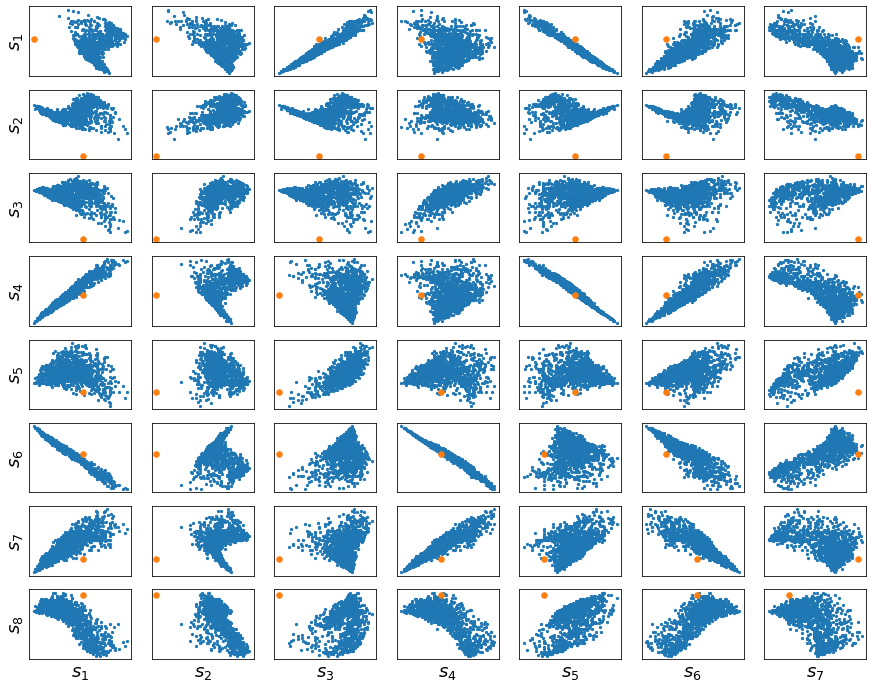

In [158]:
obs_summary = sum_net_normal(obs_real.unsqueeze(0))[1].detach().numpy()
x_summary = sum_net_normal(x[:1000])[1].detach().numpy()

stat = list(permutations(range(8), 2))

plt.figure(figsize=(15, 12))
for i in range(len(stat)):
    plt.subplot(8, 7, i+1)
    plt.scatter(x_summary[:, stat[i][1]], x_summary[:, stat[i][0]], s=5)
    plt.scatter(obs_summary[0, stat[i][1]], obs_summary[0, stat[i][0]], s=30)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i%7==0:
        plt.ylabel("$s_{i}$".format(i=stat[i][0]+1), fontsize=18)
    if len(stat)-7 <= i < len(stat):
        plt.xlabel("$s_{i}$".format(i=stat[i][1]+1), fontsize=18, fontweight="bold")
plt.savefig("turin_summary_npe.pdf")

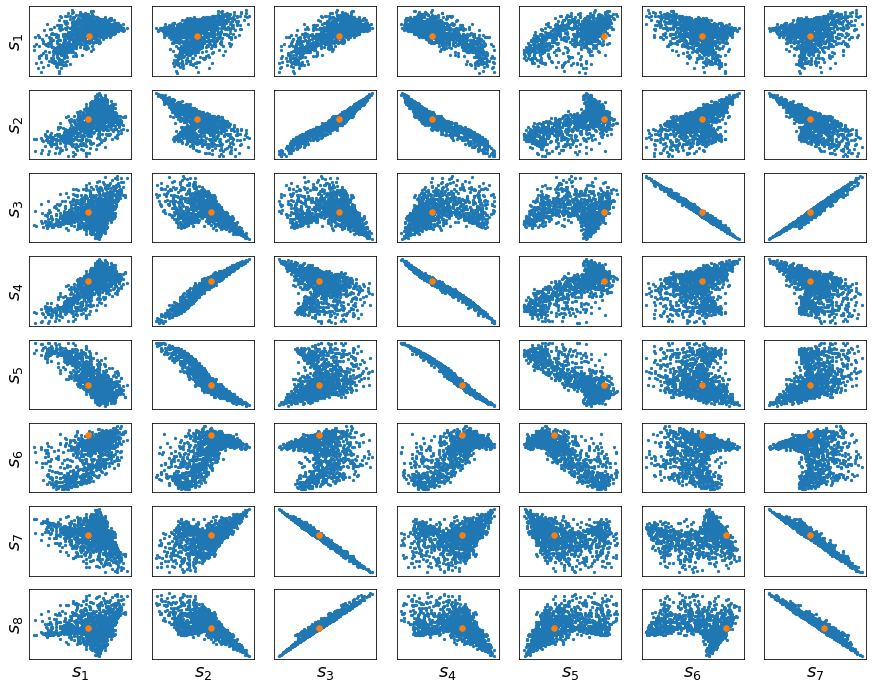

In [152]:
obs_summary = sum_net_robust(obs_real.unsqueeze(0))[1].detach().numpy()
x_summary = sum_net_robust(x[:1000])[1].detach().numpy()

stat = list(permutations(range(8), 2))

plt.figure(figsize=(15, 12))
for i in range(len(stat)):
    plt.subplot(8, 7, i+1)
    plt.scatter(x_summary[:, stat[i][1]], x_summary[:, stat[i][0]], s=5)
    plt.scatter(obs_summary[0, stat[i][1]], obs_summary[0, stat[i][0]], s=30)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i%7==0:
        plt.ylabel("$s_{i}$".format(i=stat[i][0]+1), fontsize=18)
    if len(stat)-7 <= i < len(stat):
        plt.xlabel("$s_{i}$".format(i=stat[i][1]+1), fontsize=18, fontweight="bold")
plt.savefig("turin_summary_ours.pdf")

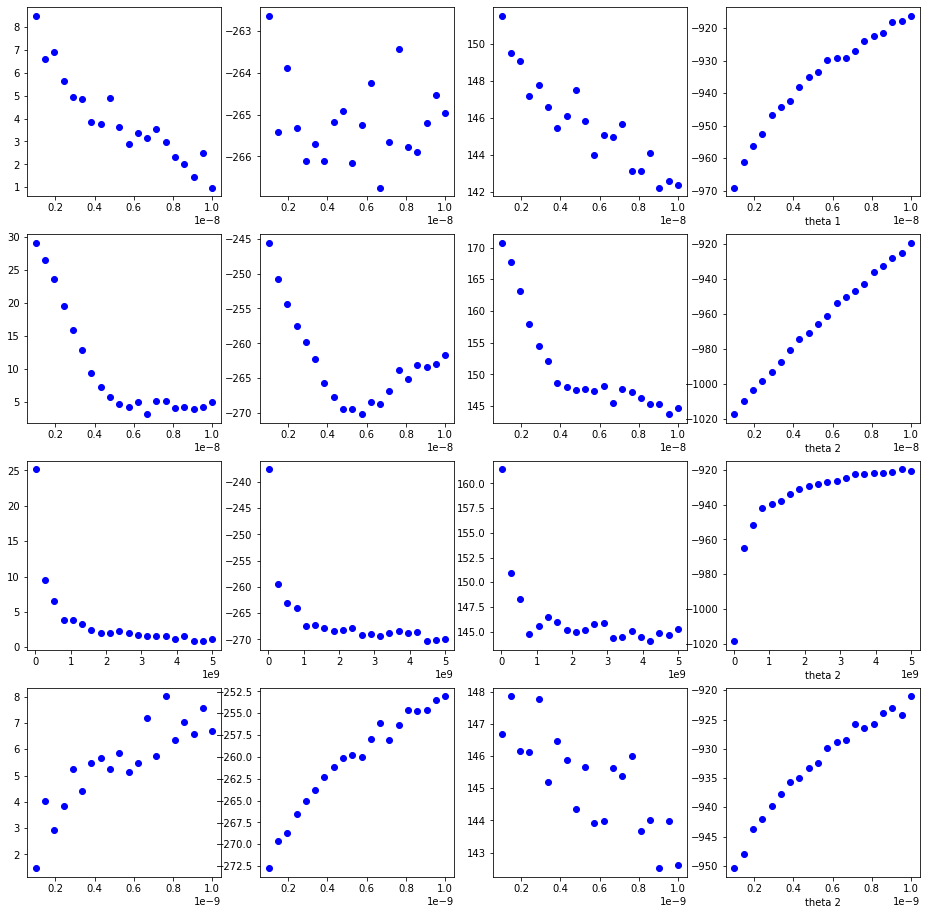

In [31]:
n_samples = 100

theta_1 = np.linspace(1e-9, 1e-8, 20)
theta_2= np.linspace(1e-9, 1e-8, 20)
theta_3 = np.linspace(1e7, 5e9, 20)
theta_4= np.linspace(1e-10, 1e-9, 20)
theta_1_unchange = np.repeat(10**(-8.4), 20)
theta_2_unchange = np.repeat(7.8e-9, 20)
theta_3_unchange = np.repeat(1e9, 20)
theta_4_unchange = np.repeat(2.8e-10, 20)

thetas_1 = torch.tensor(np.stack((theta_1, theta_2_unchange, theta_3_unchange, theta_4_unchange), axis=-1))
thetas_2 = torch.tensor(np.stack((theta_1_unchange, theta_2, theta_3_unchange, theta_4_unchange), axis=-1))
thetas_3 = torch.tensor(np.stack((theta_1_unchange, theta_2_unchange, theta_3, theta_4_unchange), axis=-1))
thetas_4 = torch.tensor(np.stack((theta_1_unchange, theta_2_unchange, theta_3_unchange, theta_4), axis=-1))

hidden_1_normal = np.zeros((len(thetas_1), 8))
hidden_2_normal = np.zeros((len(thetas_2), 8))
hidden_3_normal = np.zeros((len(thetas_3), 8))
hidden_4_normal = np.zeros((len(thetas_4), 8))

for i in range(len(thetas_1)):
    obs_1 = simulator(thetas_1[i].reshape(-1, 4)).reshape(1, n_samples, 801).to(device)
    obs_2 = simulator(thetas_2[i].reshape(-1, 4)).reshape(1, n_samples, 801).to(device)
    obs_3 = simulator(thetas_3[i].reshape(-1, 4)).reshape(1, n_samples, 801).to(device)
    obs_4 = simulator(thetas_4[i].reshape(-1, 4)).reshape(1, n_samples, 801).to(device)

    hidden_1_normal[i] = sum_net_normal(obs_1)[1].reshape(-1).cpu().detach().numpy()
    hidden_2_normal[i] = sum_net_normal(obs_2)[1].reshape(-1).cpu().detach().numpy()
    hidden_3_normal[i] = sum_net_normal(obs_3)[1].reshape(-1).cpu().detach().numpy()
    hidden_4_normal[i] = sum_net_normal(obs_4)[1].reshape(-1).cpu().detach().numpy()


plt.figure(figsize=(16,16))
plt.subplot(4, 4, 1)
plt.scatter(theta_1, hidden_1_normal[:, 0], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 0], color="red")
plt.subplot(4, 4, 2)
plt.scatter(theta_1, hidden_1_normal[:, 1], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 1], color="red")
plt.subplot(4, 4, 3)
plt.scatter(theta_1, hidden_1_normal[:, 2], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 2], color="red")
plt.subplot(4, 4, 4)
plt.scatter(theta_1, hidden_1_normal[:, 3], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 3], color="red")
plt.xlabel("theta 1")

plt.subplot(4, 4, 5)
plt.scatter(theta_2, hidden_2_normal[:, 0], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(4, 4, 6)
plt.scatter(theta_2, hidden_2_normal[:, 1], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(4, 4, 7)
plt.scatter(theta_2, hidden_2_normal[:, 2], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(4, 4, 8)
plt.scatter(theta_2, hidden_2_normal[:, 3], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")

plt.subplot(4, 4, 9)
plt.scatter(theta_3, hidden_3_normal[:, 0], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(4, 4, 10)
plt.scatter(theta_3, hidden_3_normal[:, 1], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(4, 4, 11)
plt.scatter(theta_3, hidden_3_normal[:, 2], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(4, 4, 12)
plt.scatter(theta_3, hidden_3_normal[:, 3], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")

plt.subplot(4, 4, 13)
plt.scatter(theta_4, hidden_4_normal[:, 0], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(4, 4, 14)
plt.scatter(theta_4, hidden_4_normal[:, 1], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(4, 4, 15)
plt.scatter(theta_4, hidden_4_normal[:, 2], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(4, 4, 16)
plt.scatter(theta_4, hidden_4_normal[:, 3], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")
plt.show()